In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.patches import Rectangle

In [ ]:
# Load computed measures from Zenodo.

df = pd.read_table("https://zenodo.org/records/13840227/files/measures.tsv", sep="\t", na_values='None')

In [ ]:
# Compute subcorpora statistics.

df[df["measure"].eq("text_length_tokens")].groupby("corpus_id").agg(texts=("text_id", "nunique"), tokens=("value", "sum"))

texts     tokens
corpus_id                     
itaca_L1        495   353259.0
kolipsi-2_L2    883   173785.0
leonide_L1      143    17292.0
leonide_L2      166    13556.0
pec             198  1001550.0

In [ ]:
# Define canonical order and labels for subcorpora.

corpora = {
  'pec': "PEC",
  'itaca_L1': "ITACA L1",
  'kolipsi-2_L2': "Kolipsi-2 L2",
  'leonide_L1': "LEONIDE L1",
  'leonide_L2': "LEONIDE L2",
}

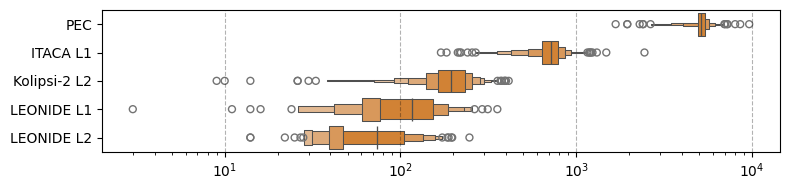

In [ ]:
# Plot subcorpora text length distributions.

df_tmp = df[df["measure"].eq("text_length_tokens")][["corpus_id", "text_id", "value"]]
df_tmp['corpus_id'] = df_tmp['corpus_id'].replace(corpora)

plt.figure(figsize=(8, 2))
ax = sns.boxenplot(
    data=df_tmp,
    y="corpus_id",
    x="value",
    order=corpora.values(),
    k_depth="tukey",
    width_method="area",
    color="#EB811B", # Metropolis' beamer theme mLightBrown
)
ax.set_xscale("log")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=0.3, color="black")

plt.tight_layout()
plt.savefig("text_lengths.pdf", format='pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# Exclude short texts that create too much noise in the plots.

tokens_lower_limit = 64
short_text_ids = df[df["measure"].eq("text_length_tokens") & df["value"].lt(tokens_lower_limit)]["text_id"]
print("We're excluding", len(short_text_ids), "texts shorter than", tokens_lower_limit, "tokens")
df = df[~df["text_id"].isin(short_text_ids)]

We're excluding 101 texts shorter than 64 tokens


In [ ]:
# Collate measure, strategy and window size combinations.

df["measure/strategy/window"] = df["measure"] + "/" + df["strategy"] + "/" + df["window"].fillna(0).astype(int).astype(str)

In [ ]:
# Define canonical order and labels for samplings.
# NOTE: we skip the most extreme ones as there isn't much to see there.

sampling = {
  #"c512": "Repeat ¹⁄₅₁₂",
  #"c256": "Repeat ¹⁄₂₅₆",
  #"c128": "Repeat ¹⁄₁₂₈",
  "c064": "Repeat ¹⁄₆₄",
  "c032": "Repeat ¹⁄₃₂",
  "c016": "Repeat ¹⁄₁₆",
  "c008": "Repeat ¹⁄₈",
  "c004": "Repeat ¹⁄₄",
  "c002": "Repeat ¹⁄₂",
  "identity": "Original",
  #"s256": "Shuffle 256g",
  #"s128": "Shuffle 128g",
  #"s064": "Shuffle 64g",
  "s032": "Shuffle 32g",
  "s016": "Shuffle 16g",
  "s008": "Shuffle 8g",
  "s004": "Shuffle 4g",
  "s002": "Shuffle 2g",
  "s001": "Shuffle 1g",
  "uniform": "Uniform",
}

# Define a palette and a simplified legend for samplings.

sampling_identity_index = list(sampling.keys()).index("identity")

palette = sns.color_palette("coolwarm", len(sampling) - 1)
palette[sampling_identity_index] = "tab:green"
palette.append("tab:brown")

legend_elements = [
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[0], label=list(sampling.values())[0]),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[1], label=list(sampling.values())[1]),
    Rectangle((0, 0), 0, 1, edgecolor='none', facecolor='none', label='...                 '),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[8-3], label=list(sampling.values())[8-3]),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[9-3], label=list(sampling.values())[9-3]),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[10-3], label=list(sampling.values())[10-3]),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[11-3], label=list(sampling.values())[11-3]),
    Rectangle((0, 0), 0, 1, edgecolor='none', facecolor='none', label='...                 '),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[18-6], label=list(sampling.values())[18-6]),
    Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=palette[19-6], label=list(sampling.values())[19-6]),
]


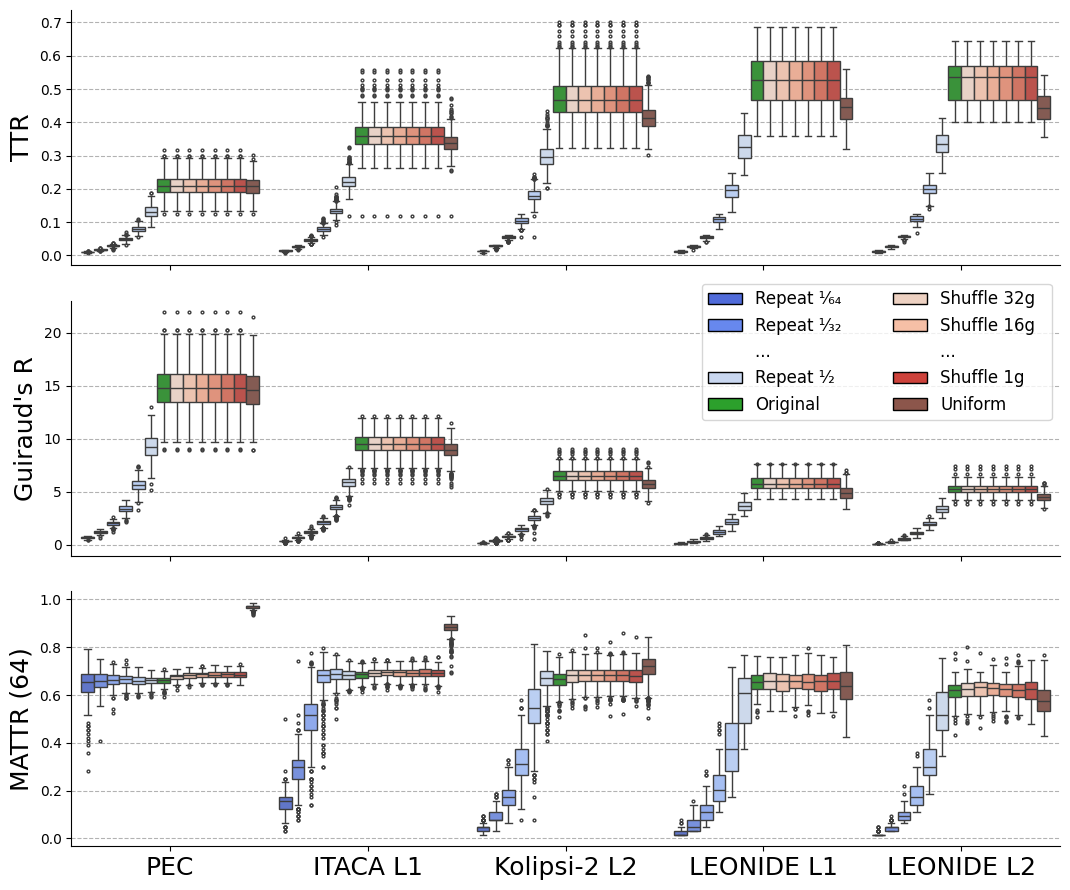

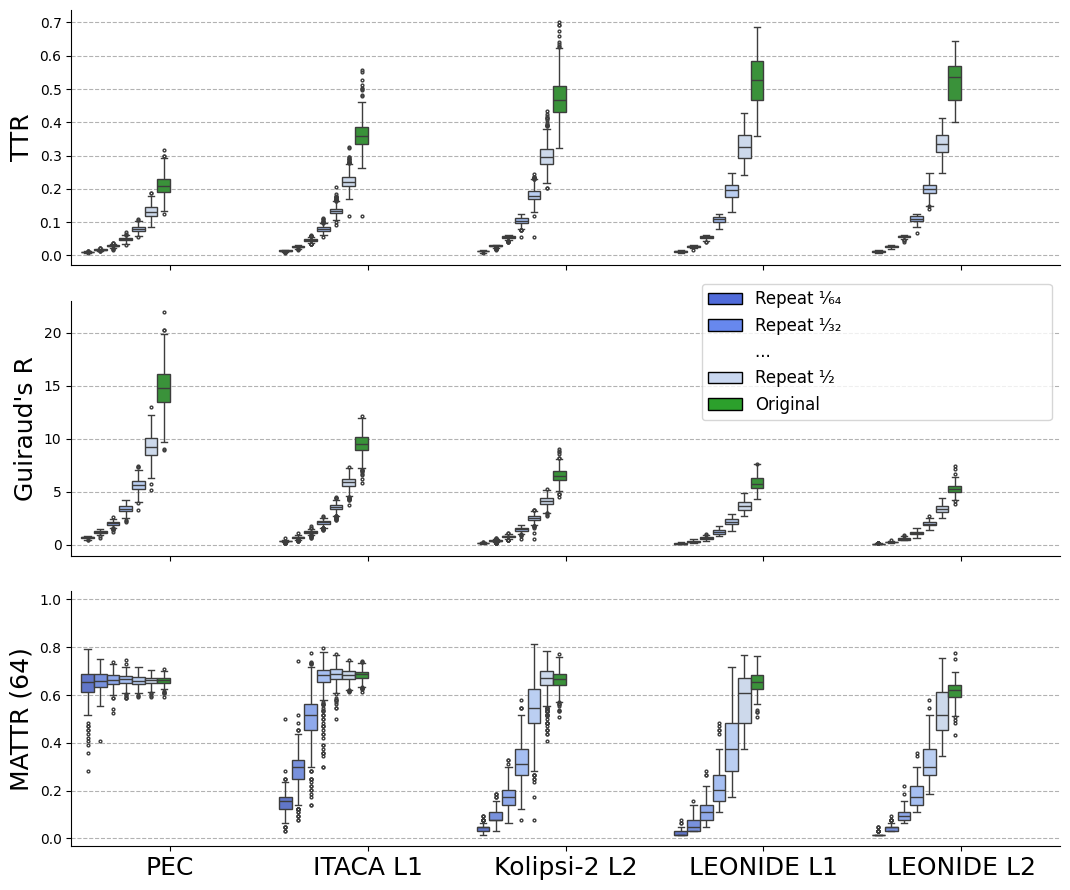

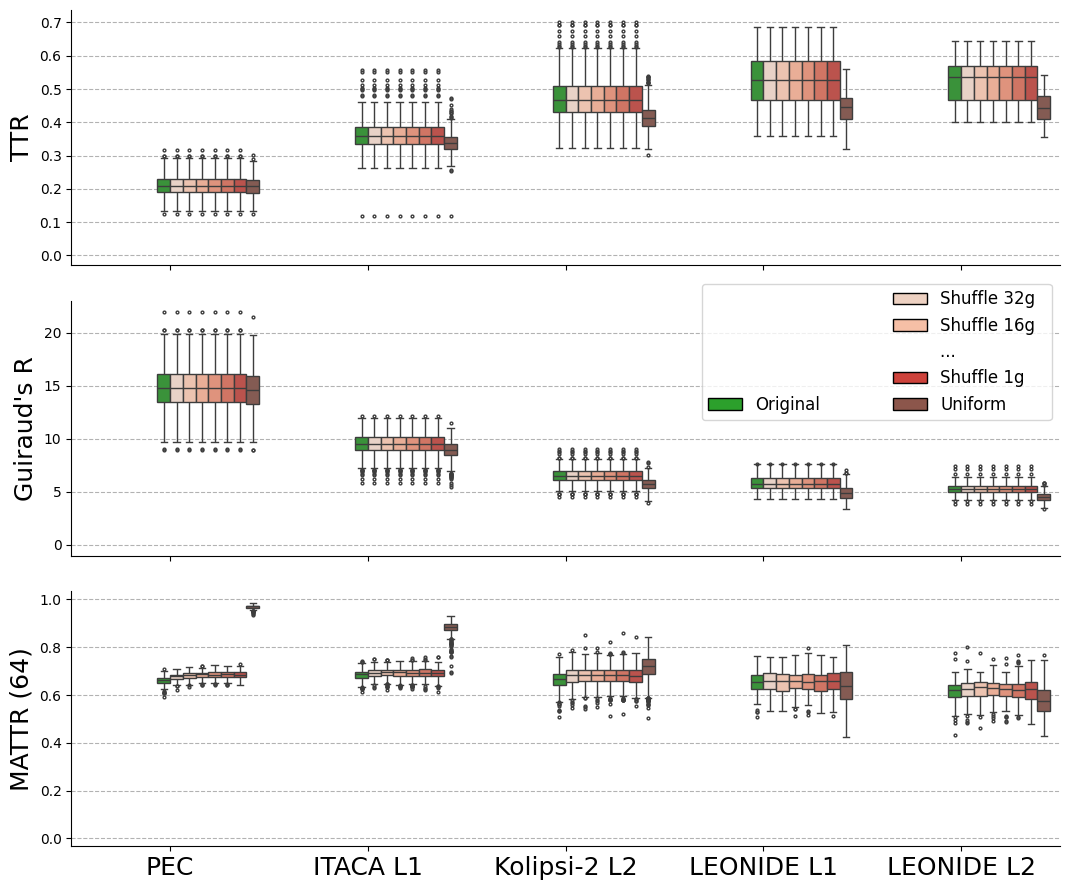

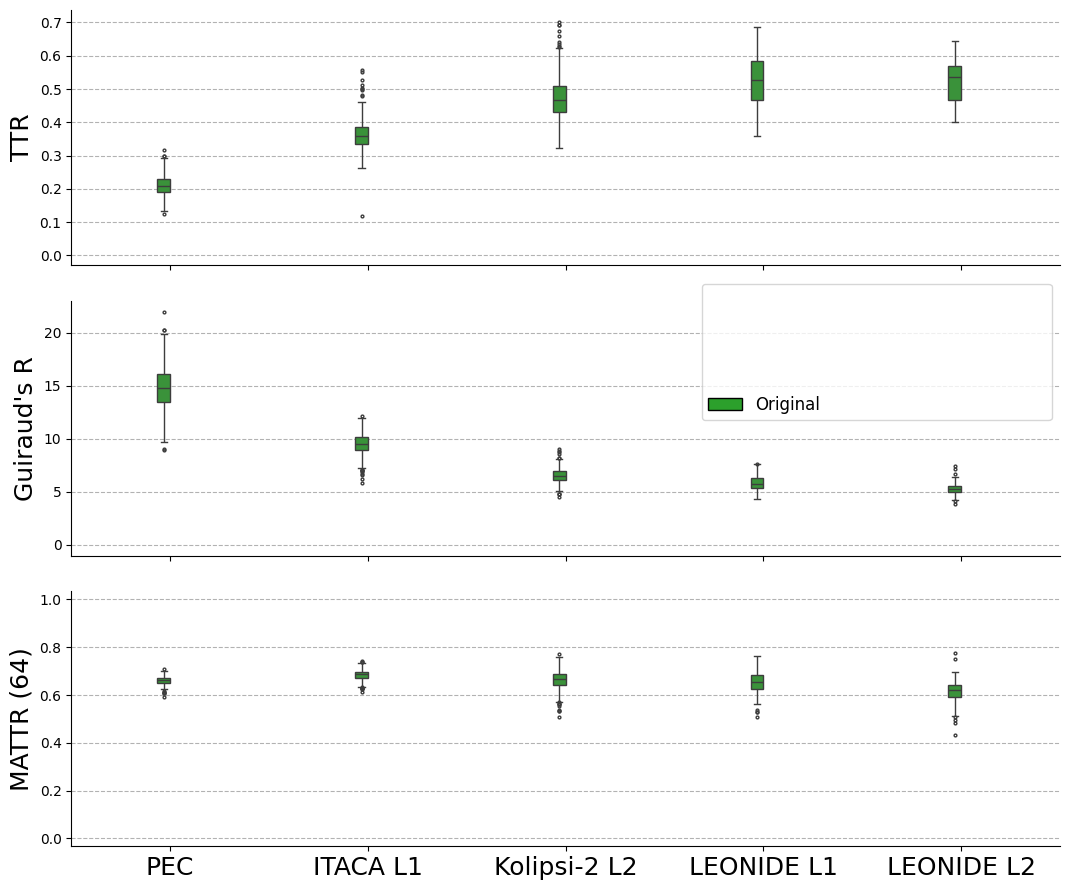

In [ ]:
rows = {
  "type_token_ratio/full_text/0": "TTR",
  "guiraud_r/full_text/0": "Guiraud's R",
  "type_token_ratio/moving_average/64": "MATTR (64)",
}

slices = {
    "cos": (slice(None, None), slice(None, None)),
    "cox": (slice(None, sampling_identity_index+1), slice(None, 5)),
    "xos": (slice(sampling_identity_index, None), slice(4, None)),
    "xox": (slice(sampling_identity_index, sampling_identity_index+1), slice(4, 5)),
}

global_ylim = None

for slice_label, (slice_range, slice_legend) in slices.items():
  df_tmp = df.copy()

  df_tmp.loc[~df_tmp['resampling'].isin(list(sampling.keys())[slice_range]), 'value'] = np.nan

  df_tmp['corpus_id'] = df_tmp['corpus_id'].replace(corpora)
  df_tmp['resampling'] = df_tmp['resampling'].replace(sampling)

  g = sns.FacetGrid(
    df_tmp, row="measure/strategy/window", col="ngram",
    row_order=rows.keys(),
    height=3, aspect=9/2.5, sharey=False,
  )
  g.map(plt.grid, axis='y', linestyle='--', alpha=0.3, color="black")
  g.map_dataframe(
      sns.boxplot, "corpus_id", "value", hue="resampling",
      order=corpora.values(), hue_order=sampling.values(), palette=palette,
      fliersize=2, width=0.9,
  )

  g.set_titles('')
  g.set_xlabels('')
  for ax in g.axes.flatten():
      ax.tick_params(axis='x', labelsize=18)

  if global_ylim is None:
      global_ylim = [ax.get_ylim() for ax in g.axes.flatten()]
  for ax, ylim in zip(g.axes.flatten(), global_ylim):
      ax.set_ylim(ylim)

  legend = g.axes[1][0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1,1.1), ncol=2, frameon=True, fontsize=12)
  for i in set(range(len(legend_elements))).difference(set(range(*slice_legend.indices(len(legend_elements))))):
    legend.get_texts()[i].set_visible(False)
    legend.get_patches()[i].set_visible(False)

  for i, v in enumerate(rows.values()):
      g.axes[i][0].set_ylabel(v, fontsize=18)

  plt.tight_layout()
  plt.savefig(f"results_ttr_{slice_label}.pdf", format='pdf', transparent=True, bbox_inches='tight')
  plt.show()

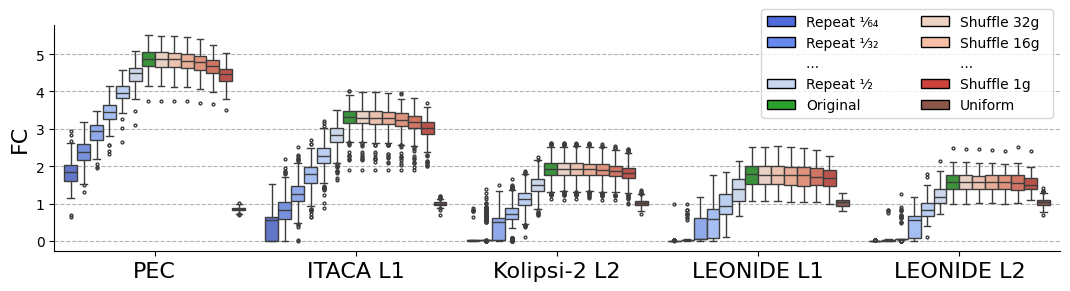

In [ ]:
rows = {
  "fluctuation_complexity/full_text/0": "FC",
}

df_tmp = df.copy()

df_tmp['corpus_id'] = df_tmp['corpus_id'].replace(corpora)
df_tmp['resampling'] = df_tmp['resampling'].replace(sampling)

g = sns.FacetGrid(
  df_tmp, row="measure/strategy/window", col="ngram",
  row_order=rows.keys(),
  height=3, aspect=9/2.5, sharey=False,
)
g.map(plt.grid, axis='y', linestyle='--', alpha=0.3, color="black")
g.map_dataframe(
    sns.boxplot, "corpus_id", "value", hue="resampling",
    order=corpora.values(), hue_order=sampling.values(), palette=palette,
    fliersize=2, width=0.9,
)

g.set_titles('')
g.set_xlabels('')
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=16)

g.axes[0][0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1,1.1), ncol=2, frameon=True, fontsize=10)

for i, v in enumerate(rows.values()):
    g.axes[i][0].set_ylabel(v, fontsize=16)

plt.tight_layout()
plt.savefig("results_fc.pdf", format='pdf', transparent=True, bbox_inches='tight')
plt.show()


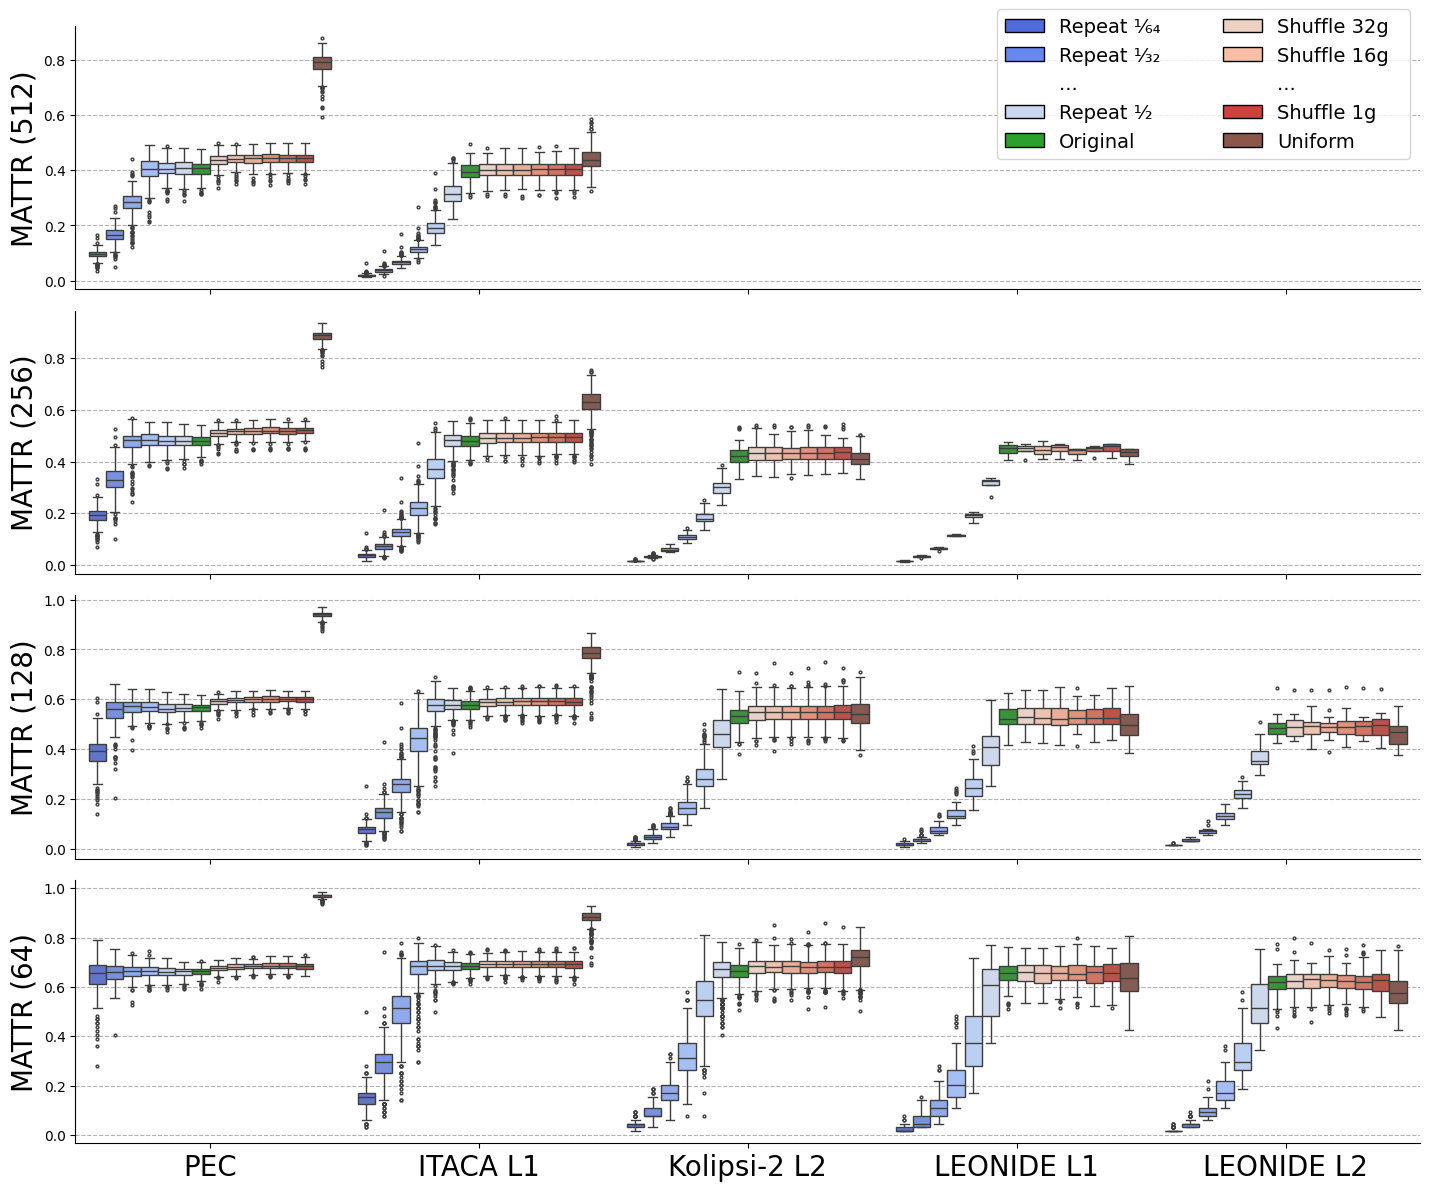

In [ ]:
rows = {
  "type_token_ratio/moving_average/512": "MATTR (512)",
  "type_token_ratio/moving_average/256": "MATTR (256)",
  "type_token_ratio/moving_average/128": "MATTR (128)",
  "type_token_ratio/moving_average/64": "MATTR (64)",
}

df_tmp = df.copy()

df_tmp['corpus_id'] = df_tmp['corpus_id'].replace(corpora)
df_tmp['resampling'] = df_tmp['resampling'].replace(sampling)

g = sns.FacetGrid(
  df_tmp, row="measure/strategy/window", col="ngram",
  row_order=rows.keys(),
  height=3, aspect=9/(2.5*3/4), sharey=False,
)
g.map(plt.grid, axis='y', linestyle='--', alpha=0.3, color="black")
g.map_dataframe(
    sns.boxplot, "corpus_id", "value", hue="resampling",
    order=corpora.values(), hue_order=sampling.values(), palette=palette,
    fliersize=2, width=0.9,
)

g.set_titles('')
g.set_xlabels('')
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=20)

for i, v in enumerate(rows.values()):
    g.axes[i][0].set_ylabel(v, fontsize=20)

g.axes[0][0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1,1.1), ncol=2, frameon=True, fontsize=14)

plt.tight_layout()
plt.savefig("results_mattr.pdf", format='pdf', transparent=True, bbox_inches='tight')
plt.show()

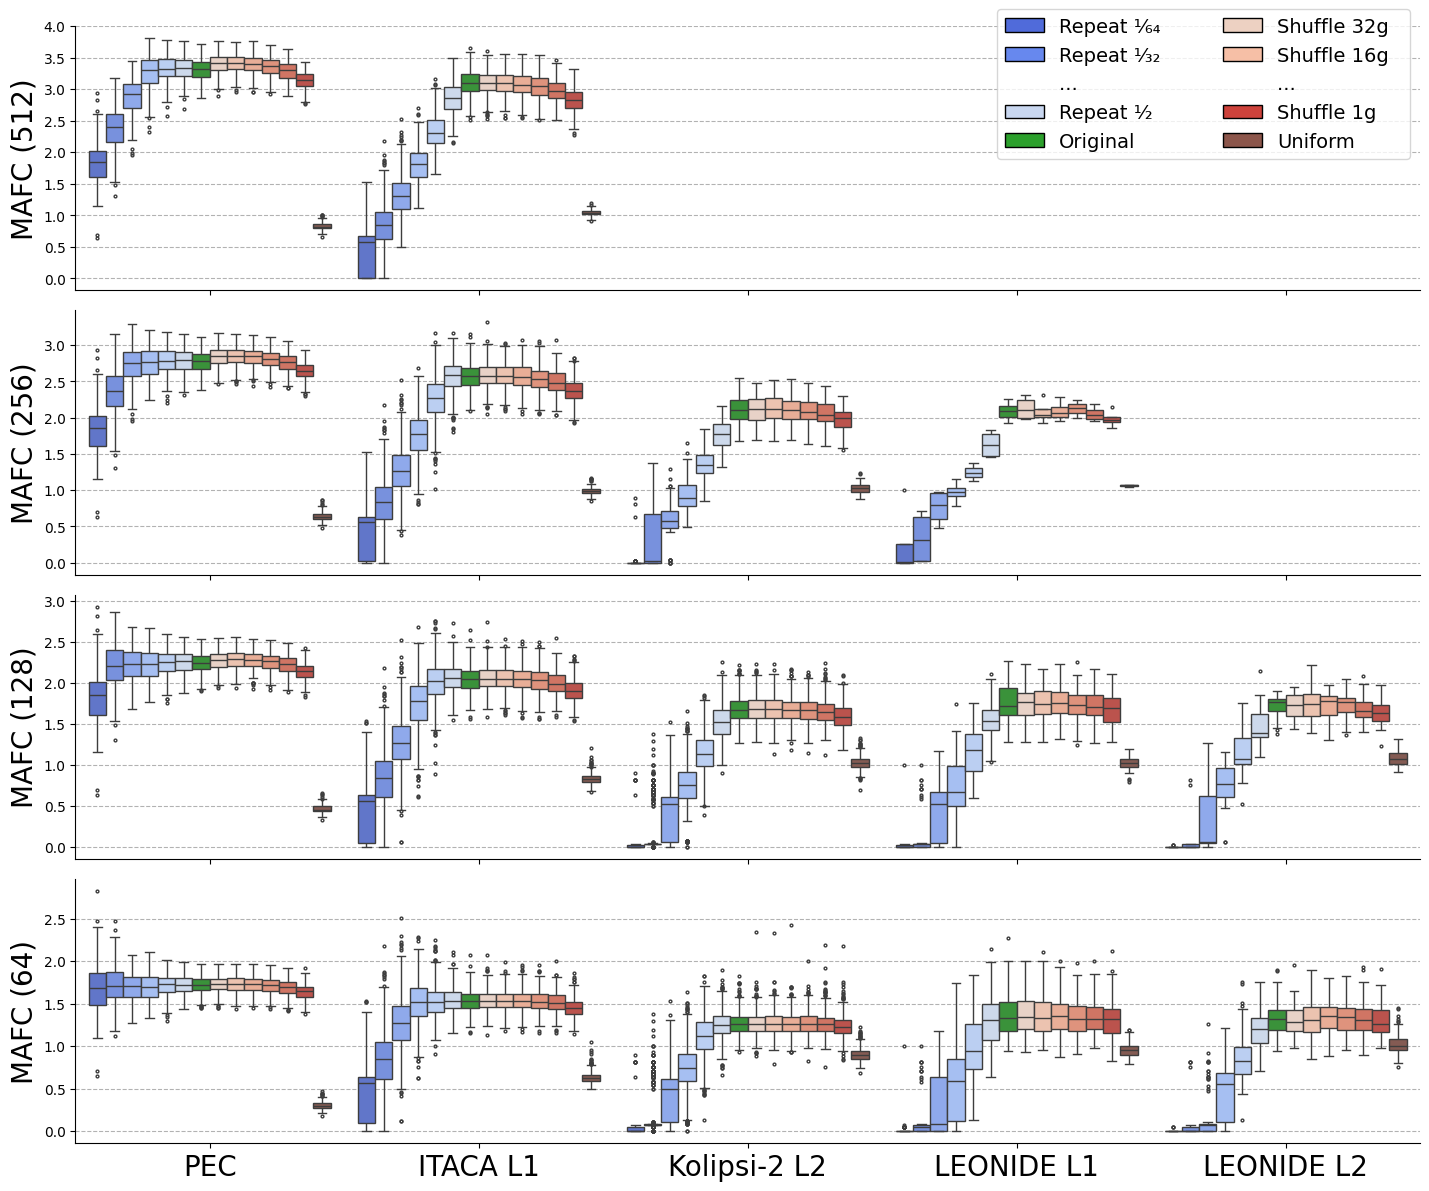

In [ ]:
rows = {
  "fluctuation_complexity/moving_average/512": "MAFC (512)",
  "fluctuation_complexity/moving_average/256": "MAFC (256)",
  "fluctuation_complexity/moving_average/128": "MAFC (128)",
  "fluctuation_complexity/moving_average/64": "MAFC (64)",
}

df_tmp = df.copy()

df_tmp['corpus_id'] = df_tmp['corpus_id'].replace(corpora)
df_tmp['resampling'] = df_tmp['resampling'].replace(sampling)

g = sns.FacetGrid(
  df_tmp, row="measure/strategy/window", col="ngram",
  row_order=rows.keys(),
  height=3, aspect=9/(2.5*3/4), sharey=False,
)
g.map(plt.grid, axis='y', linestyle='--', alpha=0.3, color="black")
g.map_dataframe(
    sns.boxplot, "corpus_id", "value", hue="resampling",
    order=corpora.values(), hue_order=sampling.values(), palette=palette,
    fliersize=2, width=0.9,
)

g.set_titles('')
g.set_xlabels('')
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=20)

for i, v in enumerate(rows.values()):
    g.axes[i][0].set_ylabel(v, fontsize=20)

g.axes[0][0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1,1.1), ncol=2, frameon=True, fontsize=14)

plt.tight_layout()
plt.savefig("results_mafc.pdf", format='pdf', transparent=True, bbox_inches='tight')
plt.show()

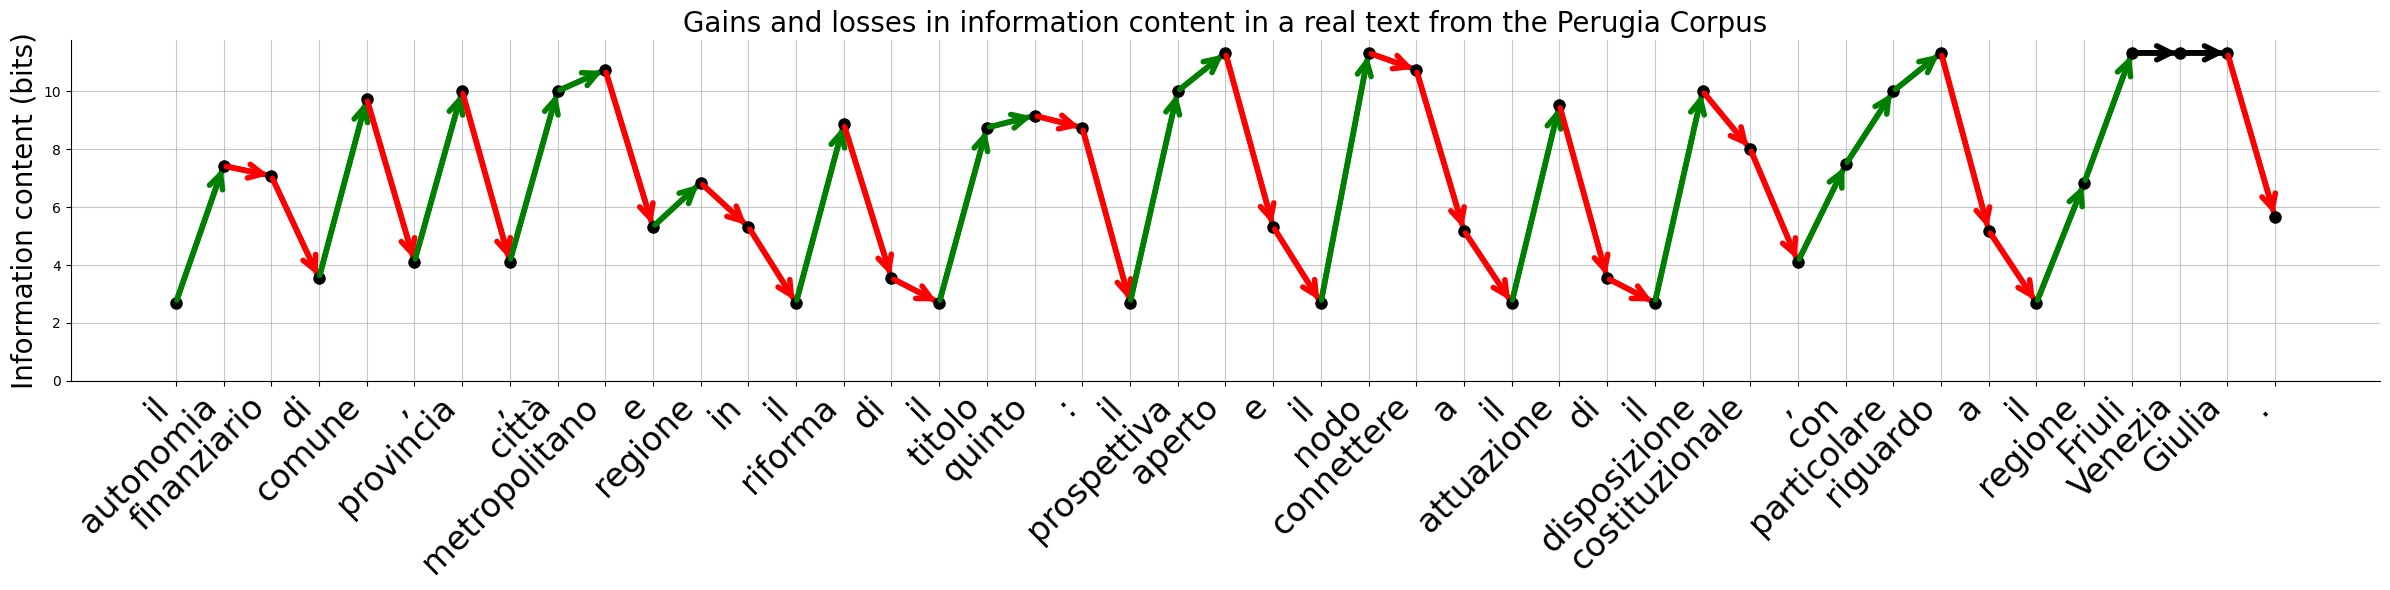

In [ ]:
%%script false --no-raise-error
# NOTE: this cell is disabled because it requires a data file that's not public.

import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Function to read CoNLL-U format and extract lemmatized tokens
def read_conllu(file_path):
    lemmatized_tokens = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('#') or line.strip() == '':
                continue
            parts = line.strip().split('\t')
            if '-' in parts[0]:
                continue
            lemma = parts[2]
            lemmatized_tokens.append(lemma)
    return lemmatized_tokens

tokens = read_conllu("target/conllu/pec/Diritto_Economia-013-tesi-diritto.conllu")

# Assuming read_conllu function and tokens are defined earlier

tokens_abs_freq = Counter(tokens)
tokens_probability = {t: c / len(tokens) for (t, c) in tokens_abs_freq.items()}
tokens_entropy = {t: - math.log2(p) for (t, p) in tokens_probability.items()}

bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens) - 1)]
bigram_info_gain = {b: tokens_entropy[b[1]] - tokens_entropy[b[0]] for b in bigrams}

info_values = [tokens_entropy[token] for token in tokens]

plt.figure(figsize=(24, 6))

for i in range(len(info_values[:44])):
    color = ['black', 'green', 'red'][int(np.sign(info_values[i+1] - info_values[i]))]
    plt.plot([i, i+1], [info_values[i], info_values[i+1]], color=color, linewidth=4)
    arrowprops = dict(arrowstyle='->', color=color, lw=4, mutation_scale=25)
    plt.annotate('', xy=(i+1, info_values[i+1]), xytext=(i, info_values[i]), arrowprops=arrowprops)

plt.plot(info_values[:45], marker='o', linestyle='', color='black', markersize=8)

plt.title('Gains and losses in information content in a real text from the Perugia Corpus', fontsize=20)
plt.ylabel('Information content (bits)', fontsize=20)

# Adjust x-axis
plt.xticks(ticks=np.arange(len(tokens[:45])), labels=tokens[:45], rotation=45, ha='right', fontsize=24)

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylim(bottom=0)
plt.grid(True, which='major', linestyle='-', alpha=0.7)

plt.tight_layout()
plt.savefig('info_gain_losses.pdf', format='pdf', transparent=True, bbox_inches='tight')
plt.show()